In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from torchinfo import summary

In [2]:
dir = 'data/original/'
training_data=np.load(f'{dir}training_data.npy', allow_pickle=True)
test_data=np.load(f'{dir}test_data.npy', allow_pickle=True)
val_data=np.load(f'{dir}val_data.npy', allow_pickle=True)
word_to_ix=np.load(f'{dir}word_to_ix.npy', allow_pickle=True).item() # words (in notes) to index
ix_to_word=np.load(f'{dir}ix_to_word.npy', allow_pickle=True).item() # index to words (in notes). not strictly needed for model
wikivec=np.load(f'{dir}newwikivec.npy', allow_pickle=True) # wiki article embeddings (# codes with wiki articles, vocab size)
wikivoc=np.load(f'{dir}wikivoc.npy', allow_pickle=True).item() # ICD-9 codes with wiki articles. not strictly needed for model

In [3]:
n_wiki, n_vocab = wikivec.shape
n_words = len(word_to_ix)
n_embedding = 100
batch_size = 32
test_batch_size = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wikivec = torch.FloatTensor(wikivec).to(DEVICE) # wikivec is a model input for KSI

In [4]:
def collate_fn(block):
    block_size = len(block)
    max_words = np.max([len(i[0]) for i in block])
    mat = np.zeros((block_size, max_words), dtype=int)
    for i in range(block_size):
        for j in range(max_words):
            try:
                if block[i][0][j] in word_to_ix:
                    mat[i,j] = word_to_ix[block[i][0][j]]
            except IndexError:
                pass
    mat = torch.from_numpy(mat)
    embeddings = torch.FloatTensor(np.array([x for _, x, _ in block]))
    labels = torch.FloatTensor(np.array([y for _, _, y in block]))
    return mat, embeddings, labels

In [5]:
train_dataloader = DataLoader(training_data, collate_fn=collate_fn, batch_size=batch_size)
val_dataloader = DataLoader(val_data, collate_fn=collate_fn, batch_size=test_batch_size)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=test_batch_size)

In [18]:
class KSI(nn.Module):
    def __init__(self, n_ksi_embedding, n_vocab):
        super().__init__()
        self.ksi_embedding = nn.Linear(n_vocab, n_ksi_embedding)
        self.ksi_attention = nn.Linear(n_ksi_embedding, n_ksi_embedding)
        self.ksi_output = nn.Linear(n_ksi_embedding, 1)
        
    def forward_ksi(self, notevec, wikivec):
        with torch.profiler.record_function("KSI Forward"):
            n = notevec.shape[0]
            n_codes = wikivec.shape[0]
            notevec = notevec.unsqueeze(1).expand(n, n_codes, -1)
            wikivec = wikivec.unsqueeze(0)
        
            z = torch.mul(wikivec, notevec)
            e = self.ksi_embedding(z)
            attention_scores = torch.sigmoid(self.ksi_attention(e))
            v = torch.mul(attention_scores, e)
            s = self.ksi_output(v)
            o = s.squeeze(2)
        
        return o
    
    
class ModifiedKSI(nn.Module):
    """Use weighted sum of note and wiki vectors instead of vector intersection"""
    def __init__(self, n_ksi_embedding, n_vocab):
        super().__init__()
        self.weights = nn.Linear(2, 1, bias=False)
        self.ksi_embedding = nn.Linear(n_vocab, n_ksi_embedding)
        self.ksi_attention = nn.Linear(n_ksi_embedding, n_ksi_embedding)
        self.ksi_output = nn.Linear(n_ksi_embedding, 1)
        
    def forward_ksi(self, notevec, wikivec):
        with torch.profiler.record_function("Modified KSI Forward"):
            n = notevec.shape[0]
            n_codes = wikivec.shape[0]
            notevec = notevec.unsqueeze(1).expand(n, n_codes, -1)
            wikivec = wikivec.unsqueeze(0).expand(n, n_codes, -1)
        
            z = self.weights(torch.stack([notevec, wikivec], dim=-1)).squeeze()
            e = self.ksi_embedding(z)
            attention_scores = torch.sigmoid(self.ksi_attention(e))
            v = torch.mul(attention_scores, e)
            s = self.ksi_output(v)
            o = s.squeeze(2)
        
        return o


class CNN(nn.Module):
    def __init__(self, n_words, n_wiki, n_embedding, ksi=None, **kwargs):
        super().__init__(**kwargs)
        self.ksi = ksi
        self.word_embeddings = nn.Embedding(n_words+1, n_embedding)
        self.dropout_embedding = nn.Dropout(p=0.2)
        self.conv1 = nn.Conv1d(n_embedding, 100, 3)
        self.conv2 = nn.Conv1d(n_embedding, 100, 4)
        self.conv3 = nn.Conv1d(n_embedding, 100, 5)
        self.output = nn.Linear(n_embedding*3, n_wiki)
    
    def forward(self, note, notevec=None, wikivec=None):
        # batch_size, n = note.shape
        with torch.profiler.record_function("CNN Embedding"):
            embeddings = self.word_embeddings(note) # (batch_size, n, n_embedding)
            embeddings = self.dropout_embedding(embeddings)
            embeddings = embeddings.permute(0, 2, 1) # (batch_size, n_embedding, n)
        
        with torch.profiler.record_function("CNN Forward"):
            a1 = F.relu(self.conv1(embeddings))
            a1 = F.max_pool1d(a1, a1.shape[2])
            a2 = F.relu(self.conv2(embeddings))
            a2 = F.max_pool1d(a2, a2.shape[2])
            a3 = F.relu(self.conv3(embeddings))
            a3 = F.max_pool1d(a3, a3.shape[2])
            combined = torch.cat([a1, a2, a3], 1).squeeze(2)
       
            out = self.output(combined)
        if self.ksi:
            out += self.ksi.forward_ksi(notevec, wikivec)
        
        scores = torch.sigmoid(out)
        return scores

In [21]:
def train(model, dataloader, loss_function, wikivec=None, optimizer=None, profiler=None, scheduler=None):
    for data in dataloader:
        optimizer.zero_grad()
        note, embeddings, labels = data
        note = note.to(DEVICE)
        embeddings = embeddings.to(DEVICE)
        labels = labels.to(DEVICE)
        scores = model(note, embeddings, wikivec)
        loss = loss_function(scores, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        if profiler:
            profiler.step()

        
def test(model, dataloader, wikivec=None, threshold=0.5, k=10, by_label=False):
    y = []
    yhat = []
    recall = []
    for data in dataloader:
        note, embeddings, labels = data
        note = note.to(DEVICE)
        embeddings = embeddings.to(DEVICE)
        out = model(note, embeddings, wikivec).cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        y.append(labels)
        yhat.append(out)
        
    y = np.concatenate(y)
    yhat = np.concatenate(yhat)
    preds = np.array(yhat > threshold, dtype=float)
    for i in range(yhat.shape[0]):
        n_labels = int(y[i, :].sum())
        topk = max(k, n_labels)
        ind_topk = np.argpartition(yhat[i, :], -topk)[-topk:]
        recall.append(y[i, ind_topk].sum() / n_labels if n_labels > 0 else np.nan)
    
    # compute macro AUC by label frequency group
    label_freq_aucs = None
    if by_label:
        code_frequencies = y.sum(axis=0)
        bin_10 = np.argwhere((code_frequencies <= 10) & (code_frequencies > 0)).squeeze()
        bin_50 = np.argwhere((code_frequencies <= 50) & (code_frequencies > 10)).squeeze()
        bin_100 = np.argwhere((code_frequencies <= 100) & (code_frequencies > 50)).squeeze()
        bin_500 = np.argwhere((code_frequencies <= 500) & (code_frequencies > 100)).squeeze()
        bin_remaining = np.argwhere(code_frequencies > 500).squeeze()
        label_freq_aucs = {}
        label_freq_aucs['1-10'] = roc_auc_score(y[:, bin_10], yhat[:, bin_10], average='macro')
        label_freq_aucs['11-50'] = roc_auc_score(y[:, bin_50], yhat[:, bin_50], average='macro')
        label_freq_aucs['51-100'] = roc_auc_score(y[:, bin_100], yhat[:, bin_100], average='macro')
        label_freq_aucs['101-500'] = roc_auc_score(y[:, bin_500], yhat[:, bin_500], average='macro')
        label_freq_aucs['>500'] = roc_auc_score(y[:, bin_remaining], yhat[:, bin_remaining], average='macro')
            
    # compute overall metrics
    mask = np.sum(y, axis=0) > 0 # mask out classes without both positive and negative examples
    recall = np.nanmean(recall)
    micro_f1 = f1_score(y[:, mask], preds[:, mask], average='micro')
    macro_f1 = f1_score(y[:, mask], preds[:, mask], average='macro')
    micro_auc = roc_auc_score(y[:, mask], yhat[:, mask], average='micro')
    macro_auc = roc_auc_score(y[:, mask], yhat[:, mask], average='macro')
    return recall, micro_f1, macro_f1, micro_auc, macro_auc, label_freq_aucs


def train_model(model, n_epochs=10, profile=False, log_path='./log'):
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=n_epochs)
    if profile: 
        with torch.profiler.profile(activities=[
                torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA,
            ], profile_memory=True, use_cuda=True, on_trace_ready=torch.profiler.tensorboard_trace_handler(log_path)) as prof:
            for epoch in range(n_epochs):
                train(model, train_dataloader, loss_function, wikivec=wikivec, optimizer=optimizer, profiler=prof, scheduler=scheduler)
                t_recall_at_k, t_micro_f1, t_macro_f1, t_micro_auc, t_macro_auc, _ = test(model, train_dataloader, wikivec)
                v_recall_at_k, v_micro_f1, v_macro_f1, v_micro_auc, v_macro_auc, _ = test(model, val_dataloader, wikivec)
                print(f'Epoch: {epoch+1:03d}, Train Recall@10: {t_recall_at_k:.4f}, Val Recall@10: {v_recall_at_k:.4f}' + 
                    f', Train Micro F1: {t_micro_f1:.4f}, Val Micro F1: {v_micro_f1:.4f}' +
                    f', Train Macro F1: {t_macro_f1:.4f}, Val Macro F1: {v_macro_f1:.4f}' +
                    f', Train Micro AUC: {t_micro_auc:.4f}, Val Micro AUC: {v_micro_auc:.4f}' +
                    f', Train Macro AUC: {t_macro_auc:.4f}, Val Macro AUC: {v_macro_auc:.4f}')
    else: 
        for epoch in range(n_epochs):
            train(model, train_dataloader, loss_function, wikivec=wikivec, optimizer=optimizer, profiler=None, scheduler=scheduler)
            t_recall_at_k, t_micro_f1, t_macro_f1, t_micro_auc, t_macro_auc, _ = test(model, train_dataloader, wikivec)
            v_recall_at_k, v_micro_f1, v_macro_f1, v_micro_auc, v_macro_auc, _ = test(model, val_dataloader, wikivec)
            print(f'Epoch: {epoch+1:03d}, Train Recall@10: {t_recall_at_k:.4f}, Val Recall@10: {v_recall_at_k:.4f}' + 
                f', Train Micro F1: {t_micro_f1:.4f}, Val Micro F1: {v_micro_f1:.4f}' +
                f', Train Macro F1: {t_macro_f1:.4f}, Val Macro F1: {v_macro_f1:.4f}' +
                f', Train Micro AUC: {t_micro_auc:.4f}, Val Micro AUC: {v_micro_auc:.4f}' +
                f', Train Macro AUC: {t_macro_auc:.4f}, Val Macro AUC: {v_macro_auc:.4f}')
    return prof if prof else None

In [8]:
# note_lengths = []
# for data in train_dataloader:
#     n, _, _ = data
#     note_lengths.append(n.shape[1])
# avg_note_size = np.round(np.array(note_lengths).mean()).astype(int)

avg_note_size = 2455

In [9]:
n_epochs = 10
save = True
profile = False

In [10]:
base_model = CNN(n_words, n_wiki, n_embedding)
base_model = base_model.to(DEVICE)
base_summary = summary(base_model, [(batch_size, avg_note_size), (batch_size, n_vocab)], dtypes=[torch.int, torch.float])

base_summary

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Embedding: 1-1                         [32, 2455, 100]           4,796,200
├─Dropout: 1-2                           [32, 2455, 100]           --
├─Conv1d: 1-3                            [32, 100, 2453]           30,100
├─Conv1d: 1-4                            [32, 100, 2452]           40,100
├─Conv1d: 1-5                            [32, 100, 2451]           50,100
├─Linear: 1-6                            [32, 344]                 103,544
Total params: 5,020,044
Trainable params: 5,020,044
Non-trainable params: 0
Total mult-adds (G): 9.60
Input size (MB): 1.87
Forward/backward pass size (MB): 251.25
Params size (MB): 20.08
Estimated Total Size (MB): 273.20

In [11]:
prof_base = train_model(base_model, n_epochs=n_epochs, profile=profile, log_path='./log/CNN')

Epoch: 001, Train Recall@10: 0.6853, Val Recall@10: 0.6770, Train Micro F1: 0.5554, Val Micro F1: 0.5435, Train Macro F1: 0.0781, Val Macro F1: 0.0910, Train Micro AUC: 0.9592, Val Micro AUC: 0.9470, Train Macro AUC: 0.7425, Val Macro AUC: 0.7196
Epoch: 002, Train Recall@10: 0.7393, Val Recall@10: 0.7216, Train Micro F1: 0.5910, Val Micro F1: 0.5717, Train Macro F1: 0.1092, Val Macro F1: 0.1223, Train Micro AUC: 0.9720, Val Micro AUC: 0.9589, Train Macro AUC: 0.8700, Val Macro AUC: 0.7813
Epoch: 003, Train Recall@10: 0.7611, Val Recall@10: 0.7345, Train Micro F1: 0.6174, Val Micro F1: 0.5895, Train Macro F1: 0.1453, Val Macro F1: 0.1409, Train Micro AUC: 0.9762, Val Micro AUC: 0.9614, Train Macro AUC: 0.9165, Val Macro AUC: 0.7954
Epoch: 004, Train Recall@10: 0.7750, Val Recall@10: 0.7398, Train Micro F1: 0.6337, Val Micro F1: 0.5960, Train Macro F1: 0.1838, Val Macro F1: 0.1534, Train Micro AUC: 0.9788, Val Micro AUC: 0.9614, Train Macro AUC: 0.9346, Val Macro AUC: 0.7901
Epoch: 005, 

In [12]:
if save:
    torch.save(base_model, f'{dir}CNN_model.pt')
if profile:
    print(prof_base.key_averages(group_by_stack_n=5).table(sort_by='self_cuda_time_total'))

In [59]:
tt_recall_at_k, tt_micro_f1, tt_macro_f1, tt_micro_auc, tt_macro_auc, label_aucs_base = test(base_model, 
                                                                                             test_dataloader, 
                                                                                             wikivec,
                                                                                             by_label=True)
print(f'Test Recall@10: {tt_recall_at_k:.4f}, Test Micro F1: {tt_micro_f1:.4f}, Test Macro F1: {tt_macro_f1:.4f}' +
      f', Test Micro AUC: {tt_micro_auc:.4f}, Test Macro AUC: {tt_macro_auc:.4f}')
del base_model

Test Recall@10: 0.7305, Test Micro F1: 0.5930, Test Macro F1: 0.1729, Test Micro AUC: 0.9583, Test Macro AUC: 0.7544


In [14]:
ksi = KSI(n_embedding, n_vocab)
ksi.to(DEVICE)
model = CNN(n_words, n_wiki, n_embedding, ksi=ksi)
model = model.to(DEVICE)
ksi_summary = summary(model, [(batch_size, avg_note_size), 
                              (batch_size, n_vocab),
                              (n_wiki, n_vocab)], 
                      dtypes=[torch.int, torch.float, torch.float])

ksi_summary

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─KSI: 1-1                               --                        --
│    └─Linear: 2-1                       --                        (recursive)
│    └─Linear: 2-2                       --                        (recursive)
│    └─Linear: 2-3                       --                        (recursive)
├─Embedding: 1-2                         [32, 2455, 100]           4,796,200
├─Dropout: 1-3                           [32, 2455, 100]           --
├─Conv1d: 1-4                            [32, 100, 2453]           30,100
├─Conv1d: 1-5                            [32, 100, 2452]           40,100
├─Conv1d: 1-6                            [32, 100, 2451]           50,100
├─Linear: 1-7                            [32, 344]                 103,544
├─KSI: 1-1                               --                        --
│    └─Linear: 2-4                

In [15]:
prof_ksi = train_model(model, n_epochs=n_epochs, profile=profile, log_path='./log/CNN_KSI')

Epoch: 001, Train Recall@10: 0.7485, Val Recall@10: 0.7327, Train Micro F1: 0.5878, Val Micro F1: 0.5708, Train Macro F1: 0.1517, Val Macro F1: 0.1561, Train Micro AUC: 0.9732, Val Micro AUC: 0.9640, Train Macro AUC: 0.8508, Val Macro AUC: 0.8364
Epoch: 002, Train Recall@10: 0.7887, Val Recall@10: 0.7621, Train Micro F1: 0.6312, Val Micro F1: 0.5991, Train Macro F1: 0.2224, Val Macro F1: 0.1994, Train Micro AUC: 0.9815, Val Micro AUC: 0.9707, Train Macro AUC: 0.9197, Val Macro AUC: 0.8554
Epoch: 003, Train Recall@10: 0.8036, Val Recall@10: 0.7644, Train Micro F1: 0.6409, Val Micro F1: 0.5997, Train Macro F1: 0.2640, Val Macro F1: 0.2041, Train Micro AUC: 0.9840, Val Micro AUC: 0.9704, Train Macro AUC: 0.9459, Val Macro AUC: 0.8483
Epoch: 004, Train Recall@10: 0.8112, Val Recall@10: 0.7665, Train Micro F1: 0.6523, Val Micro F1: 0.6015, Train Macro F1: 0.3080, Val Macro F1: 0.2192, Train Micro AUC: 0.9848, Val Micro AUC: 0.9690, Train Macro AUC: 0.9542, Val Macro AUC: 0.8416
Epoch: 005, 

In [16]:
if save:
    torch.save(model, f'{dir}CNN_KSI_model.pt')
if profile:
    print(prof_ksi.key_averages(group_by_stack_n=5).table(sort_by='self_cuda_time_total'))

In [48]:
tt_recall_at_k, tt_micro_f1, tt_macro_f1, tt_micro_auc, tt_macro_auc, label_aucs_ksi = test(model, 
                                                                                            test_dataloader, 
                                                                                            wikivec,
                                                                                            by_label=True)
print(f'Test Recall@10: {tt_recall_at_k:.4f}, Test Micro F1: {tt_micro_f1:.4f}, Test Macro F1: {tt_macro_f1:.4f}' +
      f', Test Micro AUC: {tt_micro_auc:.4f}, Test Macro AUC: {tt_macro_auc:.4f}')
del model

Test Recall@10: 0.7406, Test Micro F1: 0.5716, Test Macro F1: 0.2236, Test Micro AUC: 0.9607, Test Macro AUC: 0.8018


In [19]:
mod_ksi = ModifiedKSI(n_embedding, n_vocab)
mod_ksi.to(DEVICE)
mod_model = CNN(n_words, n_wiki, n_embedding, ksi=mod_ksi)
mod_model = mod_model.to(DEVICE)
mod_summary = summary(mod_model, [(batch_size, avg_note_size), 
                                  (batch_size, n_vocab),
                                  (n_wiki, n_vocab)], 
                      dtypes=[torch.int, torch.float, torch.float])

mod_summary

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─ModifiedKSI: 1-1                       --                        --
│    └─Linear: 2-1                       --                        (recursive)
│    └─Linear: 2-2                       --                        (recursive)
│    └─Linear: 2-3                       --                        (recursive)
│    └─Linear: 2-4                       --                        (recursive)
├─Embedding: 1-2                         [32, 2455, 100]           4,796,200
├─Dropout: 1-3                           [32, 2455, 100]           --
├─Conv1d: 1-4                            [32, 100, 2453]           30,100
├─Conv1d: 1-5                            [32, 100, 2452]           40,100
├─Conv1d: 1-6                            [32, 100, 2451]           50,100
├─Linear: 1-7                            [32, 344]                 103,544
├─ModifiedKSI: 1-1       

In [22]:
prof_mod_ksi = train_model(mod_model, n_epochs=n_epochs, profile=profile, log_path='./log/CNN_ModifiedKSI')

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
if save:
    torch.save(mod_model, f'{dir}CNN_ModifiedKSI_model.pt')
if profile:
    print(prof_mod_ksi.key_averages(group_by_stack_n=5).table(sort_by='self_cuda_time_total'))

In [ ]:
tt_recall_at_k, tt_micro_f1, tt_macro_f1, tt_micro_auc, tt_macro_auc, label_aucs_mod = test(mod_model, 
                                                                                            test_dataloader, 
                                                                                            wikivec,
                                                                                            by_label=True)
print(f'Test Recall@10: {tt_recall_at_k:.4f}, Test Micro F1: {tt_micro_f1:.4f}, Test Macro F1: {tt_macro_f1:.4f}' +
      f', Test Micro AUC: {tt_micro_auc:.4f}, Test Macro AUC: {tt_macro_auc:.4f}')
del mod_model

In [67]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [64]:
label_aucs_base = pd.DataFrame.from_dict(
    label_aucs_base, 
    orient='index', 
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_base['model'] = 'CNN'

label_aucs_ksi = pd.DataFrame.from_dict(
    label_aucs_ksi, 
    orient='index', 
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_ksi['model'] = 'KSI+CNN'

label_aucs_mod = pd.DataFrame.from_dict(
    label_aucs_mod, 
    orient='index', 
    columns=['macro_AUC']
    ).reset_index().rename({'index': 'label_frequency'}, axis=1)
label_aucs_mod['model'] = 'ModifiedKSI+CNN'

label_aucs = pd.concat([label_aucs_base, label_aucs_ksi, label_aucs_mod], axis=0)

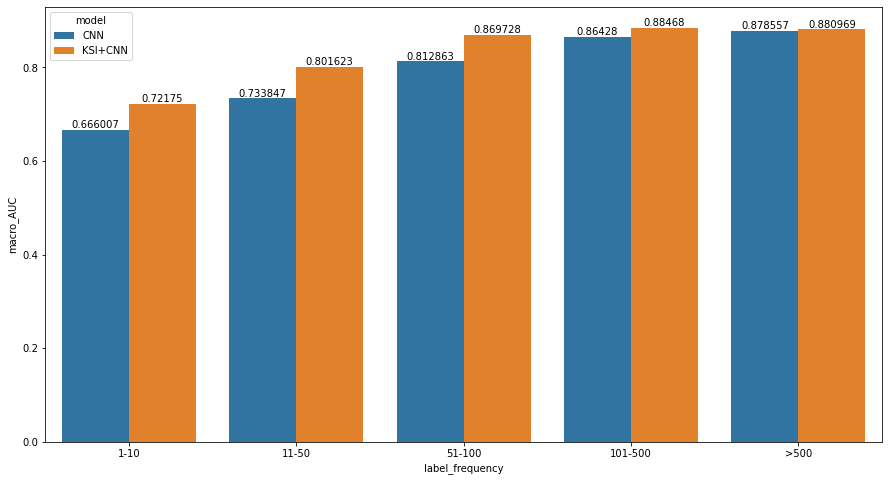

In [69]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='label_frequency', y='macro_AUC', hue='model', 
                 data=label_aucs[label_aucs['model'] != 'ModifiedKSI+CNN'])
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='label_frequency', y='macro_AUC', hue='model', 
                 data=label_aucs)
for container in ax.containers:
    ax.bar_label(container)